In [88]:
import scenvi
import scanpy as sc
import anndata as ad
import matplotlib as plt
import numpy as np

In [89]:
sc_data = sc.read_h5ad('/Users/anushka/Undergraduate-Project/MERFISH_Data/sc_data.h5ad')
st_data=sc.read_h5ad('/Users/anushka/Undergraduate-Project/MERFISH_Data/st_data.h5ad')

## STEP 1

### Filtering low quality cells/spots for both sc and st data

#### For sc data: Remove cells expressing less than 500 genes5. For ST data: Remove spots expressing less than 1 gen



In [90]:
#Plotting Gene Distribution for reducing data
import matplotlib.pyplot as plt

def plot_gene_distribution(adata, title):
    plt.figure(figsize=(10, 6))
    plt.hist(adata.obs['n_genes_by_counts'], bins=100)
    plt.title(f"{title} - Distribution of Genes per Cell/Spot")
    plt.xlabel("Number of Genes")
    plt.ylabel("Frequency")
    plt.show()

In [91]:
def filter_low_quality(adata, min_genes_percentile=10, max_genes_percentile=90):
    if 'n_genes_by_counts' not in adata.obs.columns:
        sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=None)
    
    print(f"Before filtering: {adata.n_obs} cells/spots")
    plot_gene_distribution(adata, "Before Filtering")
    
    min_genes = np.percentile(adata.obs['n_genes_by_counts'], min_genes_percentile)
    max_genes = np.percentile(adata.obs['n_genes_by_counts'], max_genes_percentile)
    
    adata = adata[(adata.obs['n_genes_by_counts'] >= min_genes) & 
                  (adata.obs['n_genes_by_counts'] <= max_genes)].copy()
    
    print(f"After filtering: {adata.n_obs} cells/spots")
    plot_gene_distribution(adata, "After Filtering")
    
    return adata

For SC DATA
Before filtering: 71183 cells/spots


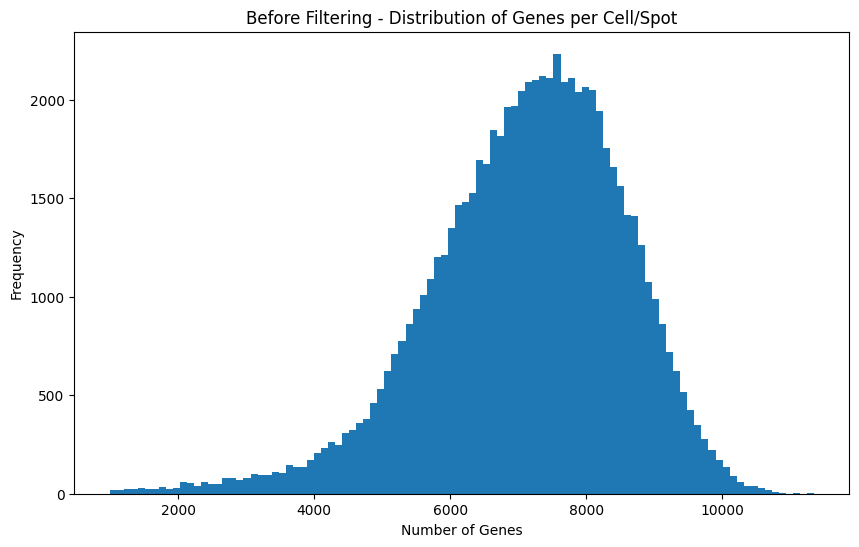

After filtering: 56959 cells/spots


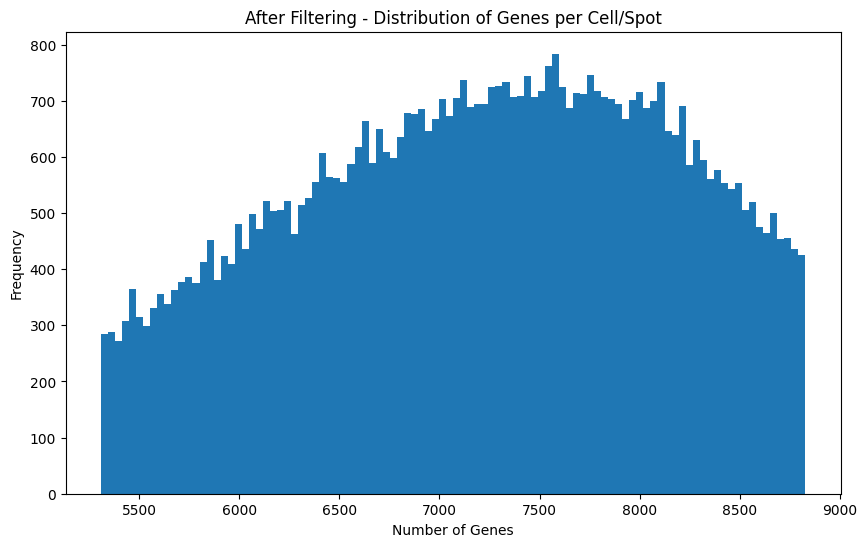

For ST DATA
Before filtering: 276556 cells/spots


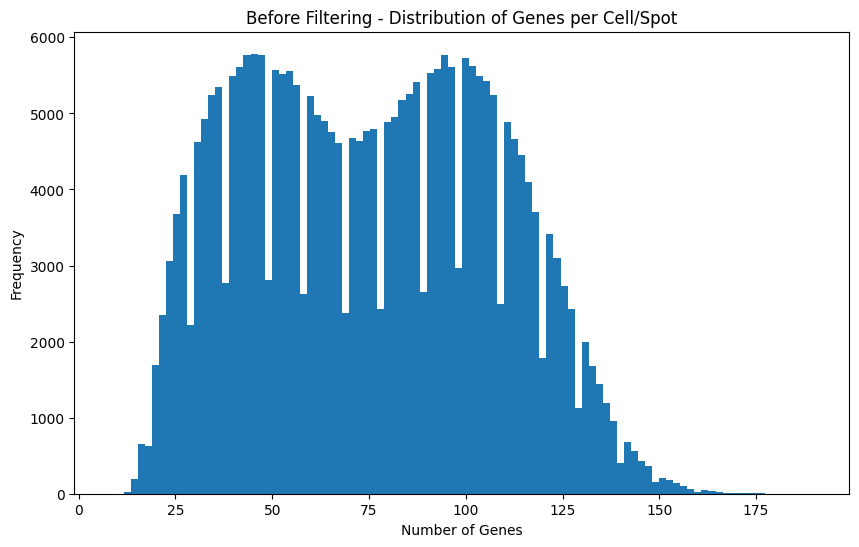

After filtering: 223626 cells/spots


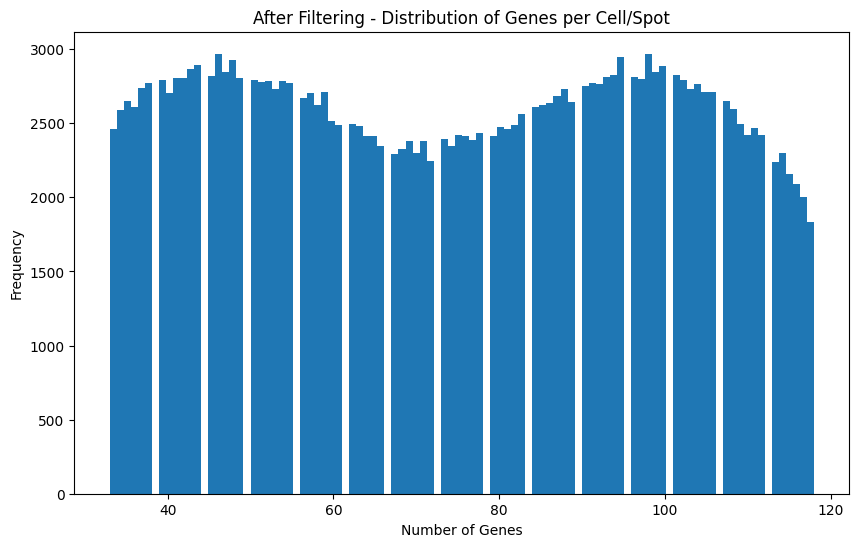

In [92]:
# Filter single-cell data
print("For SC DATA")
sc_data_filtered = filter_low_quality(sc_data, min_genes_percentile=10, max_genes_percentile=90)
print ("For ST DATA")
# Filter spatial transcriptomics data
st_data_filtered = filter_low_quality(st_data, min_genes_percentile=10, max_genes_percentile=90)

# STEP 2

### FOR ST DATA:  Performing the log1p normalization with a scale factor of 10,000

In [93]:

def normalize_st_data(adata):
    # Calculate the sum of counts per spot
    sum_counts = adata.X.sum(axis=1)
    
    # Normalize the counts
    adata.X = np.divide(adata.X, sum_counts[:, np.newaxis]) * 10000
    
    # Apply log1p transformation
    adata.X = np.log1p(adata.X)
    
    print("Normalization complete.")
    return adata


In [94]:
st_data_normalized = normalize_st_data(st_data_filtered)

Normalization complete.


#### FOR SC DATA: Using global-scaling normalization

In [ ]:
def normalize_sc_data(adata, target_sum=1e6, log=True):
    
    print("Normalizing single-cell data...")
    
    # Make a copy of the AnnData object to avoid modifying the original
    adata_norm = adata.copy()
    
    # Normalize to target sum 
    sc.pp.normalize_total(adata_norm, target_sum=target_sum)
    print(f"Data normalized to {target_sum:,} counts per cell.")
    
    if log:
        # Log-transform the data
        sc.pp.log1p(adata_norm)
        print("Data log-transformed.")
    
    print("Normalization complete.")
    return adata_norm


In [96]:
sc_data_normalized=normalize_sc_data(sc_data_filtered)

Normalizing single-cell data...
Data normalized to 1,000,000.0 counts per cell.
Data log-transformed.
Normalization complete.


In [97]:
st_data_normalized

AnnData object with n_obs × n_vars = 223626 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'cell_id', 'cell_type', 'batch', 'cell_label', 'Layer_Depth', 'Depth', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_iso', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

In [98]:
sc_data_normalized

AnnData object with n_obs × n_vars = 56959 × 30618
    obs: 'aggr_num', 'umi.counts', 'gene.counts', 'library_id', 'tube_barcode', 'Seq_batch', 'Region', 'Lib_type', 'Gender', 'Donor', 'Amp_Name', 'Amp_Date', 'Amp_PCR_cyles', 'Lib_Name', 'Lib_Date', 'Replicate_Lib', 'Lib_PCR_cycles', 'Lib_PassFail', 'Cell_Capture', 'Lib_Cells', 'Mean_Reads_perCell', 'Median_Genes_perCell', 'Median_UMI_perCell', 'Saturation', 'Live_percent', 'Total_Cells', 'Live_Cells', 'method', 'exp_component_name', 'mapped_reads', 'unmapped_reads', 'nonconf_mapped_reads', 'total.reads', 'doublet.score', 'cluster_label', 'subclass_label', 'class_label', 'cell_type', 'cell_label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

## STEP 3

#### For ST DATA: Performing Principal Component Analysis for dimension reduction 

In [99]:
#The n_comps parameter sets the number of components to compute (default is 50).
def perform_pca(adata, n_comps=50):
    print("Performing PCA...")
    sc.tl.pca(adata, n_comps=n_comps, svd_solver='arpack')
    print(f"PCA completed. {n_comps} principal components computed.")
    return adata

Performing PCA...
PCA completed. 50 principal components computed.
Variance ratio of the principal components:
[0.12199204 0.10179677 0.06157622 0.05423057 0.04912618 0.04119039
 0.03001294 0.0288354  0.0265978  0.02408711 0.02249962 0.02042053
 0.01969089 0.01857808 0.01787838 0.0170317  0.01648912 0.01495401
 0.0143769  0.01350202 0.01313855 0.01254039 0.01171072 0.01167147
 0.01117352 0.01075876 0.01051376 0.01001254 0.00935336 0.00888491
 0.00874655 0.00835301 0.00814098 0.00802915 0.00746887 0.00736016
 0.00709364 0.00681716 0.00638466 0.00615966 0.00602826 0.00585628
 0.00568101 0.00559158 0.00536168 0.00534619 0.00499373 0.00483237
 0.00475172 0.00465635]


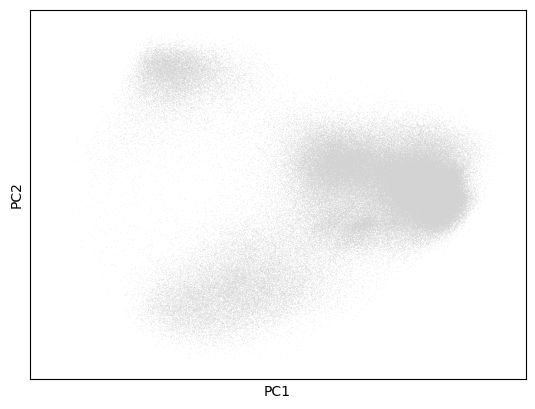

In [100]:
# Assuming st_data_normalized is your normalized AnnData object
st_data_pca = perform_pca(st_data_normalized, n_comps=50)

# To view the variance ratio of the principal components
print("Variance ratio of the principal components:")
print(st_data_pca.uns['pca']['variance_ratio'])

# To plot the PCA results
sc.pl.pca(st_data_pca)

#### FOR SC DATA : PCA

In [ ]:
def perform_pca_sc(adata, n_comps=50, svd_solver='arpack', plot=True):
    
    print(f"Performing PCA with {n_comps} components...")
    
    # Perform PCA
    sc.tl.pca(adata, n_comps=n_comps, svd_solver=svd_solver)
    print("PCA completed.")
    
    # if plot:
    #     # Plot PCA results
    #     print("Generating PCA plots...")
    #     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    #     # Scatter plot of first two PCs
    #     sc.pl.pca(adata, ax=ax1)
    #     ax1.set_title("PCA: First Two Components")
    
    #     # Elbow plot of explained variance ratio
    #     sc.pl.pca_variance_ratio(adata, n_pcs=n_comps)
    #     plt.title("PCA: Explained Variance Ratio")
    
    #     plt.tight_layout()
    #     plt.show()
    
    print(f"PCA results stored in adata.obsm['X_pca'] and adata.varm['PCs']")
    return adata




Performing PCA with 50 components...
PCA completed.
PCA results stored in adata.obsm['X_pca'] and adata.varm['PCs']
Variance ratio of the principal components:
[0.02538576 0.02169721 0.01777647 0.01080964 0.00675845 0.00596029
 0.00533159 0.00415229 0.00337963 0.00326774 0.00279985 0.00225322
 0.00204618 0.00190201 0.00160919 0.00145    0.00138644 0.00128431
 0.00123201 0.00114078 0.00091577 0.0008629  0.00080958 0.00075971
 0.00074879 0.00074077 0.00067624 0.00065679 0.00061335 0.00059313
 0.00056461 0.00055244 0.00052676 0.00051644 0.00049794 0.00046398
 0.0004366  0.00041304 0.00040619 0.00039905 0.00038211 0.00037441
 0.00035325 0.00034878 0.000333   0.00032859 0.00032211 0.00031115
 0.00030344 0.00030212]


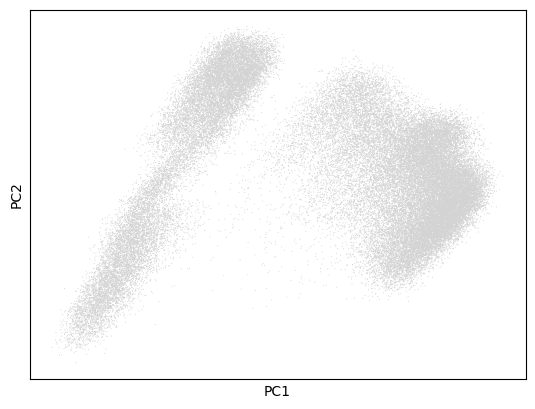

In [125]:
sc_data_pca = perform_pca_sc(sc_data_normalized, n_comps=50, plot=True)
# To view the variance ratio of the principal components
print("Variance ratio of the principal components:")
print(sc_data_pca.uns['pca']['variance_ratio'])

# To plot the PCA results
sc.pl.pca(sc_data_pca)

In [126]:
sc_data_pca

AnnData object with n_obs × n_vars = 56959 × 15996
    obs: 'aggr_num', 'umi.counts', 'gene.counts', 'library_id', 'tube_barcode', 'Seq_batch', 'Region', 'Lib_type', 'Gender', 'Donor', 'Amp_Name', 'Amp_Date', 'Amp_PCR_cyles', 'Lib_Name', 'Lib_Date', 'Replicate_Lib', 'Lib_PCR_cycles', 'Lib_PassFail', 'Cell_Capture', 'Lib_Cells', 'Mean_Reads_perCell', 'Median_Genes_perCell', 'Median_UMI_perCell', 'Saturation', 'Live_percent', 'Total_Cells', 'Live_Cells', 'method', 'exp_component_name', 'mapped_reads', 'unmapped_reads', 'nonconf_mapped_reads', 'total.reads', 'doublet.score', 'cluster_label', 'subclass_label', 'class_label', 'cell_type', 'cell_label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [127]:
st_data_pca

AnnData object with n_obs × n_vars = 223626 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'cell_id', 'cell_type', 'batch', 'cell_label', 'Layer_Depth', 'Depth', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_iso', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'

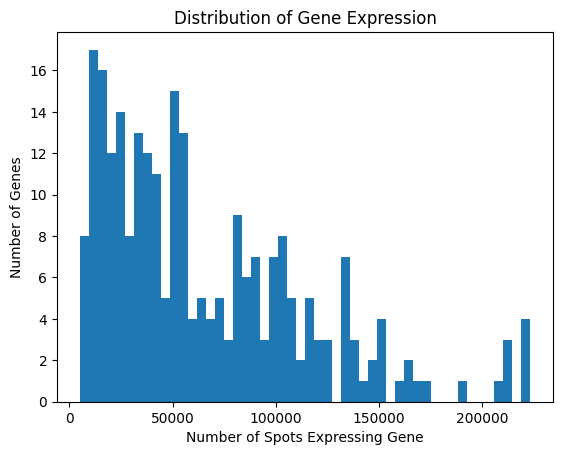

In [107]:
import matplotlib.pyplot as plt
import numpy as np

gene_counts = np.sum(st_data_pca.X > 0, axis=0)  # Count spots where gene is expressed
plt.hist(gene_counts, bins=50)
plt.xlabel("Number of Spots Expressing Gene")
plt.ylabel("Number of Genes")
plt.title("Distribution of Gene Expression")
plt.show()


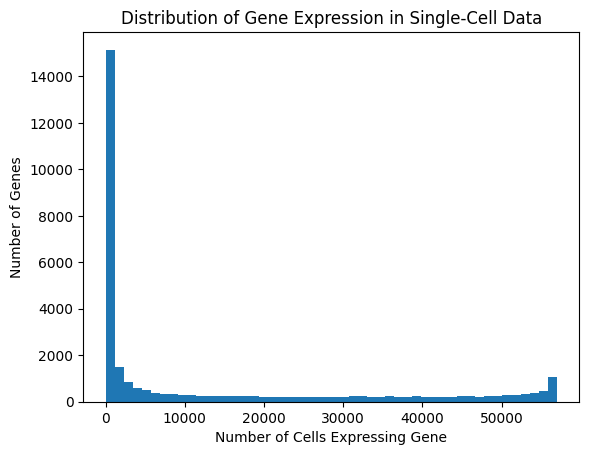

In [108]:
# Assuming sc_data_pca is your sc data AnnData object after PCA
# If you haven't read the file yet, uncomment the following line:
#sc_data_pca = sc.read_h5ad("sc_data_pca.h5ad")

gene_counts = np.sum(sc_data_pca.X > 0, axis=0)  # Count cells where gene is expressed
plt.hist(gene_counts, bins=50)
plt.xlabel("Number of Cells Expressing Gene")
plt.ylabel("Number of Genes")
plt.title("Distribution of Gene Expression in Single-Cell Data")
plt.show()


### Saving the data files

In [ ]:
# sc_data_pca_copy= sc_data_pca
# st_data_pca_copy=st_data_pca

### WITH MIN CELLS= 2000 , file size is 3.28gb . Try increasing it

In [129]:
adata_sc = sc_data_pca
# Filter genes expressed in less than X cells (adjust X based on your data)
min_cells = 2000# Example: Keep genes expressed in at least 5 cells
sc.pp.filter_genes(adata_sc, min_cells=min_cells)

print(f"Number of genes after filtering: {adata_sc.n_vars}")


Number of genes after filtering: 14257


In [130]:
adata_sc

AnnData object with n_obs × n_vars = 56959 × 14257
    obs: 'aggr_num', 'umi.counts', 'gene.counts', 'library_id', 'tube_barcode', 'Seq_batch', 'Region', 'Lib_type', 'Gender', 'Donor', 'Amp_Name', 'Amp_Date', 'Amp_PCR_cyles', 'Lib_Name', 'Lib_Date', 'Replicate_Lib', 'Lib_PCR_cycles', 'Lib_PassFail', 'Cell_Capture', 'Lib_Cells', 'Mean_Reads_perCell', 'Median_Genes_perCell', 'Median_UMI_perCell', 'Saturation', 'Live_percent', 'Total_Cells', 'Live_Cells', 'method', 'exp_component_name', 'mapped_reads', 'unmapped_reads', 'nonconf_mapped_reads', 'total.reads', 'doublet.score', 'cluster_label', 'subclass_label', 'class_label', 'cell_type', 'cell_label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [131]:
import os

merfish_data_dir = "MERFISH_Data"
if not os.path.exists(merfish_data_dir):
    os.makedirs(merfish_data_dir)

# Construct the full file paths for saving the processed data
sc_data_path = os.path.join(merfish_data_dir, "sc_data_processed.h5ad")
st_data_path = os.path.join(merfish_data_dir, "st_data_processed.h5ad")

# Save the processed data to the specified paths
adata_sc.write(sc_data_path)
st_data_pca.write(st_data_path)

print(f"sc data saved to: {sc_data_path}")
print(f"st data saved to: {st_data_path}")

sc data saved to: MERFISH_Data/sc_data_processed.h5ad
st data saved to: MERFISH_Data/st_data_processed.h5ad
